# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders_prepared import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

# Warm start - берем только те user_id, которые есть в train
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(2375, N=200)

[899624,
 1044078,
 871756,
 844179,
 5569230,
 8090537,
 1046545,
 1106523,
 883932,
 832678,
 823704,
 5569845,
 944534,
 865456,
 1000753,
 1004906,
 1004390,
 6534480,
 1051323,
 8090521,
 12301839,
 854852,
 9836106,
 965267,
 925862,
 999714,
 8065410,
 965766,
 1081177,
 1092937,
 5585510,
 850102,
 823990,
 1022428,
 1097458,
 9835223,
 896862,
 1116376,
 963727,
 865528,
 8090539,
 832442,
 1029743,
 879504,
 1068719,
 937292,
 999270,
 1134678,
 828106,
 861279,
 12262978,
 6534578,
 952163,
 1133312,
 8090509,
 999858,
 841220,
 870547,
 5568378,
 863447,
 1059902,
 947858,
 896613,
 12302069,
 1070702,
 5568197,
 1096573,
 835530,
 999779,
 1001702,
 847790,
 1056509,
 5568995,
 888543,
 1021324,
 1009770,
 1025535,
 848029,
 998239,
 874972,
 825343,
 9832469,
 838186,
 1038663,
 12301109,
 845208,
 1000736,
 856827,
 6534077,
 827919,
 1096635,
 1042907,
 995896,
 12731714,
 1131344,
 902172,
 956599,
 940090,
 938138,
 1099905,
 883068,
 998556,
 862799,
 12352293,
 1230

In [6]:
recommender.get_own_recommendations(2375, N=200)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674,
 10308345,
 1069531,
 974766,
 1015474,
 950935,
 847066,
 1102207,
 1020770,
 9521787,
 974265,
 940996,
 8019845,
 5567194,
 12811490,
 1003616,
 973181,
 890719,
 982955,
 9677152,
 998519,
 1072685,
 1131382,
 1021715,
 12263119,
 960791,
 7441873,
 986021,
 956666,
 1038692,
 9677748,
 9297223,
 927030,
 12757653,
 1046919,
 6391532,
 989069,
 1068451,
 951954,
 835300,
 937343,
 1047249,
 13876348,
 1061732,
 981601,
 1121028,
 1087547,
 828393,
 996269,
 951951,
 1036093,
 1023815,
 5570408,
 827667,
 1082454,
 1006878,
 5570048,
 841309,
 1078652,
 1115553,
 1056492,
 1138467,
 1004945,
 947858,
 1092885,
 1121694,
 938138,
 8019916,
 827919,
 984315,
 10341855,
 883932,
 8291322,
 1096794,
 1028938,
 1087618,
 8020166,
 1082185,
 866871,
 930666,
 825994,
 910151,
 823990,
 848029,
 896613,
 12301839,
 1117219,
 1135258,
 869868,
 1046545,
 899624,
 6442594,
 1137775,
 825343,
 104290

In [7]:
recommender.get_similar_items_recommendation(2375, N=200)

[1046545,
 1044078,
 937292,
 842125,
 15778319,
 1051323,
 999104,
 12810466,
 885863,
 1025535,
 863447,
 878996,
 906923,
 871611,
 999714,
 919681,
 828106,
 933835,
 1021522,
 1086384,
 1070702,
 999104,
 958594,
 12301100,
 899624,
 1121028,
 891752,
 823721,
 985999,
 1023815,
 896862,
 1068719,
 1000753,
 1086740,
 928342,
 993912,
 918994,
 1055503,
 1022428,
 1021139,
 5574358,
 916122,
 839152,
 6464180,
 1065538,
 936753,
 947201,
 858001,
 8065410,
 1056005,
 1053754,
 960732,
 8020234,
 7441210,
 904574,
 1069312,
 995896,
 828106,
 883068,
 1105488,
 1022254,
 825343,
 1120559,
 1137688,
 899459,
 819400,
 8090537,
 882247,
 5568378,
 948650,
 884103,
 12262778,
 1098435,
 969941,
 1089025,
 969945,
 1093490,
 1008799,
 5568378,
 9296821,
 937292,
 12301109,
 1055503,
 12132277,
 7410320,
 858999,
 5568489,
 1139142,
 839818,
 902172,
 908236,
 13072850,
 999625,
 862010,
 1048507,
 1004945,
 9553288,
 937292,
 885863,
 1087547,
 1008799,
 1065167,
 8011291,
 951855,
 70

In [8]:
recommender.get_similar_users_recommendation(2375, N=200)

[1096573,
 935578,
 1133654,
 835618,
 1015474,
 949345,
 7082640,
 993838,
 8090612,
 977559,
 1088771,
 8090542,
 1097398,
 894360,
 1115069,
 825317,
 1008288,
 8090956,
 8019902,
 7146026,
 861494,
 992650,
 918046,
 1040416,
 1138596,
 6533936,
 1081533,
 847962,
 1134296,
 950935,
 7160764,
 1087411,
 908314,
 938165,
 9859017,
 902377,
 1096573,
 1056212,
 1069256,
 1074040,
 10204149,
 937110,
 13007846,
 1021519,
 1107760,
 928749,
 875392,
 918638,
 943522,
 1028891,
 884694,
 875089,
 891632,
 870515,
 1075765,
 835351,
 9553335,
 842423,
 875089,
 869868,
 872066,
 884089,
 949257,
 988736,
 822970,
 6904613,
 821741,
 847962,
 935578,
 1075765,
 841365,
 977374,
 1116253,
 1055403,
 1132956,
 1029549,
 1102207,
 1080888,
 995408,
 1134006,
 1138596,
 1039360,
 1065259,
 1055403,
 918638,
 875089,
 1069256,
 929410,
 854133,
 1096573,
 839208,
 898121,
 1083043,
 985605,
 875392,
 5568072,
 820011,
 962967,
 1086740,
 993838,
 7160764,
 841236,
 958067,
 927277,
 8090550,
 

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1 = result_lvl_1.loc[result_lvl_1['user_id'] != 296]
result_lvl_1 = result_lvl_1.loc[result_lvl_1['user_id'] != 1813]

result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [12]:
%%time
# топ-100 популярных товаров
top_100 = recommender.top_purchases.head(100).item_id.to_list()
# userids: 296, 1813
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=200))
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=200))

result_lvl_1['100own_100top'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=100)
                                                                        + top_100)

result_lvl_1.head(4)

CPU times: user 44min 12s, sys: 3min 19s, total: 47min 32s
Wall time: 45min 26s


,user_id,actual,als,own,similar_items,similar_users,100own_100top
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082212, 13008334, 5577022, 856942, 912704, 8...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1088387, 826597, 9297615, 5577022, 9297191, 9...","[1010578, 1126045, 12487154, 7024847, 5564850,...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 6534480, 5569845, 919534, 5570048, 8...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[9419422, 971474, 1054402, 8293439, 942045, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[891423, 944588, 1082212, 982790, 6391541, 846...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1099446, 846550, 1111786, 999714, 821741, 854...","[8357825, 1095393, 862535, 906202, 9365106, 10...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[951834, 878996, 1084036, 1026118, 965267, 857...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[7442505, 1015280, 948640, 1113675, 1025650, 9...","[13003092, 972416, 995598, 923600, 1138596, 10..."


In [13]:
for column in result_lvl_1.columns[1:]:
    recall = result_lvl_1.apply(lambda x: recall_at_k(x[column], x['actual'], k=200), axis=1).mean()
    print(f'{column} - recall_at_5: {recall}')

actual - recall_at_5: 0.9947282436174922
als - recall_at_5: 0.0990182255391956
own - recall_at_5: 0.13537278412833254
similar_items - recall_at_5: 0.08635218331530341
similar_users - recall_at_5: 0.016233089253707395
100own_100top - recall_at_5: 0.10751997969046655


In [16]:
n_candidats = [20, 50, 100, 200, 300, 400, 500]
recalls = []
for n in n_candidats:
    result_lvl_1[f'als_{n}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=n))
    recall = result_lvl_1.apply(lambda x: recall_at_k(x[f'als_{n}'], x['actual'], k=n), axis=1).mean()
    recalls.append(recall)

recalls

[0.030101422524280996,
 0.04944923140953381,
 0.07056247763595297,
 0.0990182255391956,
 0.11864667611451837,
 0.13455022788080945,
 0.14704436184801561]

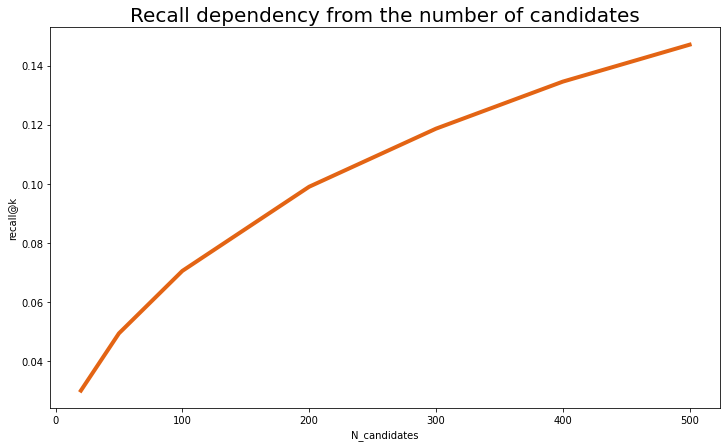

In [17]:
plt.figure(figsize = (12, 7))

plt.title('Recall dependency from the number of candidates', size=20)

plt.plot(n_candidats, recalls, label='mean', linestyle='solid', linewidth=4, color='#e36414')

plt.xlabel('N_candidates')
plt.ylabel('recall@k')
plt.show()

Для эксперимента использована модель ALS. На графике видно, что с ростом числа кандидатов recall возрастает, и среди выбранных значений N, 500 кандидатов дает самую высокую метрику. При 500 кандидатах модель второго уровня будет работать медленнее, но более эффективно, по-этому, лучше взять это значение.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)